<a href="https://colab.research.google.com/github/cserock/colab-examples/blob/main/04_CNN_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EB%A5%98_%EB%AA%A8%EB%8D%B8_%EA%B0%9C%EC%84%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN 기반 이미지 분류

`tf.keras.Sequential` 모델을 사용하여 꽃 이미지를 분류하고 `tf.keras.utils.image_dataset_from_directory`를 사용하여 데이터를 로드하는 방법을 보여줍니다.

## 설정

TensorFlow 및 기타 필요한 라이브러리를 가져옵니다.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## 데이터세트 다운로드 및 탐색하기

아래 파일을 다운로드합니다.  
https://drive.google.com/file/d/1CetAhdag_67V9mjAiB2l7ldufS8OX5oA/view?usp=sharing  
압축을 풀면 약 3,700장의 꽃 사진 데이터세트를 확인할 수 있습니다. 데이터세트에는 클래스당 하나씩 5개의 하위 디렉터리가 있습니다.

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

구글 드라이브에 연동하고 /content/drive/MyDrive/lg-dx/ 경로에 업로드합니다.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pathlib
data_dir = "/content/drive/MyDrive/lg-dx/flower_photos"
data_dir = pathlib.Path(data_dir).with_suffix('')

업로드된 폴더를 불러와서 데이터세트 사본을 사용할 수 있습니다. 총 3,670개의 이미지가 있습니다.

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


장미의 경우는 다음과 같습니다.

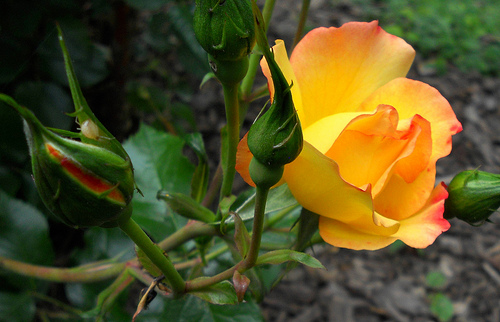

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

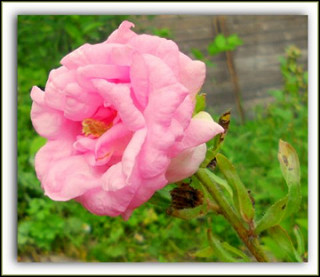

In [7]:
PIL.Image.open(str(roses[1]))

그리고 일부 튤립이 있습니다.

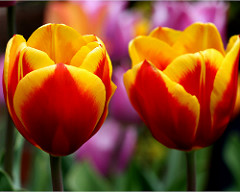

In [8]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

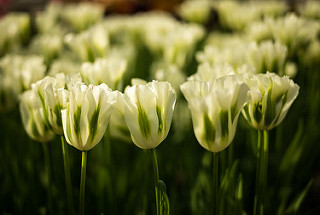

In [9]:
PIL.Image.open(str(tulips[1]))

## Keras 유틸리티를 사용하여 데이터 로드하기

다음으로, 유용한 `tf.keras.utils.image_dataset_from_directory` 유틸리티를 사용하여 디스크에서 이러한 이미지를 로드해 보겠습니다. 이러면 몇 줄의 코드로 디스크의 이미지 디렉터리에서 `tf.data.Dataset`로 이동하게 됩니다.

### 데이터세트 만들기

로더에 대한 몇 가지 매개변수를 정의합니다.

In [10]:
batch_size = 32
img_height = 180
img_width = 180

모델을 개발할 때 검증 분할을 사용하는 것이 좋습니다. 이미지의 80%를 훈련에 사용하고 20%를 검증에 사용합니다.

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


이러한 데이터세트의 `class_names` 속성에서 클래스 이름을 찾을 수 있습니다. 이들 클래스 이름은 알파벳 순서의 디렉토리 이름에 해당합니다.

In [13]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## 데이터 시각화하기

다음은 훈련 데이터세트의 처음 9개 이미지입니다.

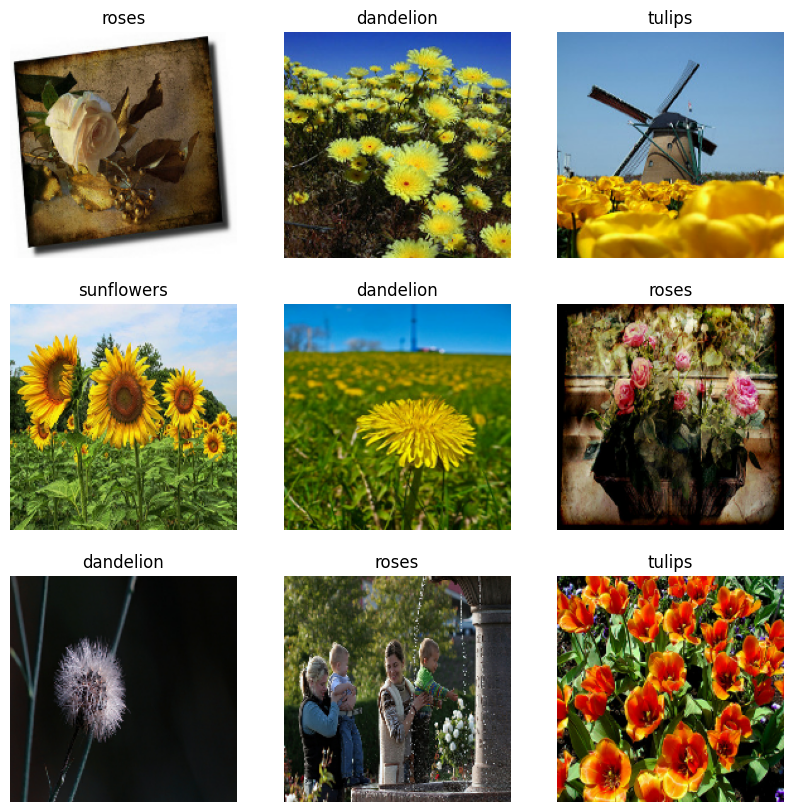

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

이 튜토리얼의 뒷부분에서 훈련을 위해 이러한 데이터세트를 `Model.fit` 메서드에 전달합니다. 원하는 경우 데이터세트를 수동으로 반복하고 이미지 배치를 가져올 수도 있습니다.

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`image_batch`는 `(32, 180, 180, 3)` 형상의 텐서이며, `180x180x3` 형상의 32개 이미지 묶음으로 되어 있습니다(마지막 차원은 색상 채널 RGB를 나타냄). `label_batch`는 형상 `(32,)`의 텐서이며 32개 이미지에 해당하는 레이블입니다.

`image_batch` 및 `labels_batch` 텐서에서 `.numpy()`를 호출하여 이를 `numpy.ndarray`로 변환할 수 있습니다.


## 성능을 높이도록 데이터세트 구성하기

버퍼링된 프리페치를 사용하여 I/O를 차단하지 않고 디스크에서 데이터를 생성할 수 있도록 하겠습니다. 데이터를 로드할 때 다음 두 가지 중요한 메서드를 사용해야 합니다.

- `Dataset.cache()`는 첫 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.
- `Dataset.prefetch`는 훈련하는 동안 데이터 전처리 및 모델 실행을 중첩시킵니다.

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 데이터 표준화하기

RGB 채널 값은 `[0, 255]` 범위에 있습니다. 이것은 신경망에 이상적이지 않습니다. 일반적으로 입력 값을 작게 만들어야 합니다.

여기에서 `tf.keras.layers.Rescaling`을 사용하여 값을 `[0, 1]` 범위로 표준화합니다.

In [17]:
normalization_layer = layers.Rescaling(1./255)

참고: 이전에 `tf.keras.utils.image_dataset_from_directory`의 `image_size` 인수를 사용하여 이미지 크기를 조정했습니다. 해당 모델에도 크기 조정 논리를 포함하려면 `tf.keras.layers.Resizing` 레이어를 사용할 수 있습니다.

## 기본 Keras 모델

### 모델 만들기

Keras [순차형](https://www.tensorflow.org/guide/keras/sequential_model) 모델은 각각에 최대 풀링 레이어(`tf.keras.layers.MaxPooling2D`)가 있는 1개의 컨볼루션 블록(`tf.keras.layers.Conv2D`)으로 구성됩니다. ReLU 활성화 함수(`'relu'`)에 의해 활성화되는 128개 유닛이 있는 완전 연결된 레이어(`tf.keras.layers.Dense`)가 있습니다.

In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 모델 컴파일하기

이 튜토리얼에서는 `tf.keras.optimizers.Adam` 옵티마이저와 `tf.keras.losses.SparseCategoricalCrossentropy` 손실 함수를 선택합니다. 각 훈련 epoch에 대한 훈련 및 검증 정확도를 보려면 `metrics` 인수를 `Model.compile`에 전달합니다.

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 모델 요약

Keras `Model.summary` 메서드를 사용하여 네트워크의 모든 레이어를 봅니다.

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 129600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,588,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,590,021 (63.29 MB)

 Trainable params: 16,590,021 (63.29 MB)

 Non-trainable params: 0 (0.00 B)

### 모델 훈련하기

Keras `Model.fit` 메서드를 사용하여 10 epoch 동안 모델을 훈련합니다.

In [23]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9782 - loss: 0.1236 - val_accuracy: 0.5640 - val_loss: 1.3867
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9921 - loss: 0.0724 - val_accuracy: 0.5463 - val_loss: 1.5112
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9906 - loss: 0.0551 - val_accuracy: 0.5286 - val_loss: 1.7629
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9822 - loss: 0.0916 - val_accuracy: 0.5300 - val_loss: 1.7556
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9939 - loss: 0.0340 - val_accuracy: 0.5409 - val_loss: 1.6611
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9924 - loss: 0.0348 - val_accuracy: 0.5518 - val_loss: 1.8052
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9995 - loss: 0.0120 - val_accuracy: 0.5395 - val_loss: 1.9076
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9998 - loss: 0.0062 - val_accuracy: 0.5341 - v

## 훈련 결과 시각화하기

훈련 및 검증 세트에 대한 손실과 정확성 플롯을 생성합니다.

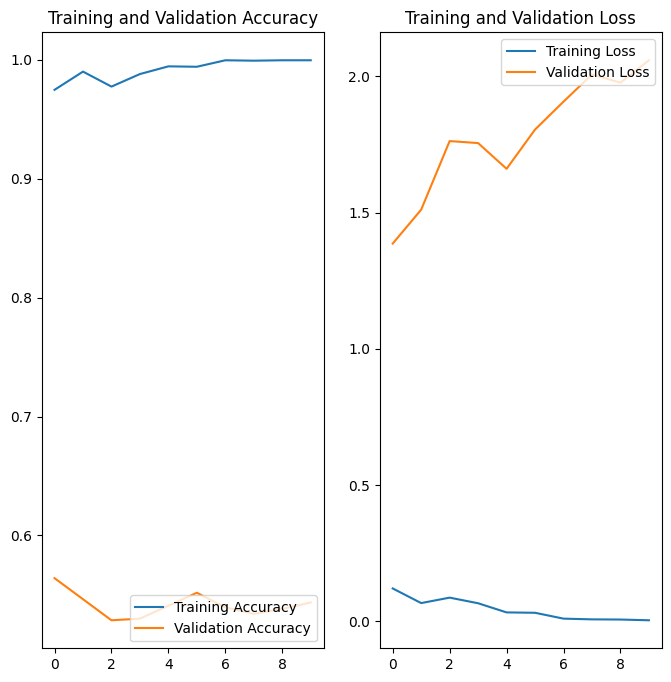

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 과대적합

위의 플롯에서 훈련 정확성은 시간이 지남에 따라 선형적으로 증가하는 반면, 검증 정확성은 훈련 과정에서 약 60%를 벗어나지 못합니다. 또한 훈련 정확성과 검증 정확성 간의 정확성 차이가 상당한데, 이는 [과대적합](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)의 징후입니다.

훈련 예제가 적을 때 모델은 새로운 예제에서 모델의 성능에 부정적인 영향을 미치는 정도까지 훈련 예제의 노이즈나 원치 않는 세부까지 학습합니다. 이 현상을 과대적합이라고 합니다. 이는 모델이 새 데이터세트에서 일반화하는 데 어려움이 있음을 의미합니다.